In [1]:
import casadi as ca
import numpy as np

import scipy
from polytope import Polytope
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

In [2]:
np.random.seed(1)

In [3]:
def eps_MRPI(A, W, epsilon, s_max=20):
    ''' Determines an outer epsilon-approximation of a minimal RPI set.

    Implements Algorithm 1 Raković et al. [1] for determining an outer 
    epsilon-approximation of the minimal RPI set for the autonomous system
    x+ = A*x + w
    using the following algorithm (copied directly from the paper and referenced 
    throughout the code):

    ALGORITHM 1: Computation of an RPI, outer epsilon-approximation of the MRPI 
    set F_infinity
    REQUIRE: A, W, and epsilon > 0
    ENSURE: F(alpha, s) such that 
        F_infinity <= F(alpha, s) <= F_infinity + B_infinity^n(epsilon)
      1: Choose any s in N (ideally, set s <- 0).
      2: REPEAT
      3:   Increment s by one.
      4:   Compute alpha^o(s) as in (11) and set alpha <- alpha^o(s).
      5:   Compute M(s) as in (13).
      6: UNTIL alpha <= epsilon / (epsilon + M(s))
      7: Compute F_s as the Minkowski sum (2) and scale it to give 
         F(alpha, s) := (1 - alpha)^(-1) * F_s.

    The s-term Minkowski sum (2) is computed in V-rep; computing the sum in
    H-rep can be both slow and numerically more challenging.

    Args:
    A: A numpy array (the state transition matrix --  must be strictly stable).
    W: A Polytope instance that bounds the disturbance w (must be compact and
      contain the origin).
    epsilon: A (positive) error bound (the radius of the infinity-norm ball).
    s_max: An optional maximum value of s, at which the algorithm terminates.

    Returns:
    F_alpha_s: A Polytope instance that is the outer-epsilon approximation of
      the MRPI set for (A, W).
    result: A dict with keys
      alpha: A scalar in [0, 1]:  A^s W subset alpha W  (Eq. (4)).
      s: A positive integer:  F_alpha_s := (1 - alpha)^(-1) F_s  (Eq. (5)).
      M: A numpy array (shape (s + 1,)) of the numbers M(k), k = 0, ..., s.
        The last element, M[-1], is M(s), which satisfies
        alpha <= epsilon / (epsilon + M(s))  (Eq. (14)).
      status: 0 if the algorithm terminated successfully, otherwise -1.
      alpha_o_s: A numpy array (shape (s + 1,)) of the number alpha at
        every iteration k = 0, ..., s.
      F_s: A numpy array of Polytope instances: F_s[s] is the s-term Minkowski
        sum from i = 0 to s over A^i W  (Eq. (2)).
      eps_min: The minimal epsilon that does not require increasing s.

    Raises:
    ValueError: An argument did not satisfy a necessary condition or the support
      function could not be evaluated successfully.

    Paper reference:
    [1] Raković, S.V., Kerrigan, E.C., Kouramas, K.I., & Mayne, D.Q. (2005).
    Invariant approximations of the minimal robust positively invariant set. IEEE
    Transactions on Automatic Control, 50(3), 406-410.
    '''

    status = -1  # set to 0 at successful termination (as in SciPy's linprog)

    m, n = A.shape
    if m != n:
        raise ValueError('A must be a square matrix')

    # The disturbance set W is in the form
    # W := {w in R^n | f_i' * w <= g_i, i in I}
    W.minimize_V_rep()
    F = W.A  # the columns f_i of A in the H-rep [A b] of W
    g = W.b  # the right-hand side b in the H-rep [A b] of W
    I = g.size  # the number of inequalities in the H-rep of W

    if not all(g > 0):
        raise ValueError('W does not contain the origin: g > 0 is not satisfied')

    # array of upper bounds on alpha values -- the scaling factor in the subset
    # condition A^s W subset alpha * W  (Eq. (10))
    alpha_o_s = np.full(s_max, np.nan)

    # To determine M(s) (used to bound the approximation error on F(alpha, s)):
    # Store support functions for each power of A, A^(s-1),
    # and each direction j = 1, ..., n. One row per s, each row has n support
    # functions for A^(s-1) positive and n for A^(s-1) negative; see (13).
    # M(s) is the maximum of all elements of each row s.
    # Store all values used to determine M(s) -- this is not necessary but useful
    # when debugging numerically challenging cases. Note that the first row
    # (s = 0) remains all zero (which is OK).
    M_s_row = np.zeros((s_max, 2 * n))  # each M(s) is the max over 2n values
    M = np.full(s_max, np.nan)  # M[s] is that maximum for each s

    # Pre-compute all powers of A, A^s, s = 0, ..., s_max

#     print(np.linalg.matrix_power(A, 0),np.linalg.matrix_power(A, 1),np.linalg.matrix_power(A, 2))
    A_pwr = np.stack([np.linalg.matrix_power(A, i) for i in range(s_max)])

    alpha_o = np.full(I, np.nan)

    # Step 1: Choose any s in N [natural numbers] (ideally, set s <- 0).
    s = 0

    # Step 2: repeat
    while s < s_max - 1:

        # Step 3: Increment s by one.
        s += 1

        # Step 4: Compute alpha^o(s) as in (11) and set alpha <- alpha^o(s).
        # alpha^o(s) = max_{i in I) h_W((A^s)' f_i) / g_i
        for i in range(I):
            fi = F[i, :].T
            h_W_i, status = W.support(A_pwr[s].T @ fi)
            if not status.success:
                print(f'Unsuccessful evaluation of the support function 'f'h_W((A^{s})'' * f_{s}): {status.message}')
            alpha_o[i] = h_W_i / g[i]
        alpha_o_s[s] = np.max(alpha_o)
        alpha = alpha_o_s[s]

        # Step 5: Compute M(s) as in (13).
        # M(s) = max_j {sum_i(h_W_sm1_pos_j), sum_i(h_W_sm1_neg_j)}  (Eq. (13))
        # At iteration s, evaluate the support for the rows of A^(s-1) and use the
        # supports evaluated at previous iterations s to evaluate the sum over i,
        # i = 0, ..., s - 1.
        h_W_sm1_pos_j = np.full(n, np.nan)  # h_W((A^(s-1))' * e_j, j = 0, ..., n-1
        h_W_sm1_neg_j = np.full(n, np.nan)  # h_W((-A^(s-1))' * e_j, j = 0, ..., n-1
        # Evaluate support in direction +- (A^i)' * e_j, with e_j the jth standard
        # basis vector in R^n. That is, (A^i)' * e_j is the jth column of (A^i)', or
        # the jth row of A^i (A_pwr_i[j])
        for j in range(n):
            A_pwr_i = A_pwr[s - 1]  # i = 0, ..., s - 1
            h_W_sm1_pos_j[j], status_lhs = W.support(A_pwr_i[j])
            h_W_sm1_neg_j[j], status_rhs = W.support(-A_pwr_i[j])
            if not all(status.success for status in (status_lhs, status_rhs)):
                raise ValueError(f'Unsuccessful evaluation of the support function in 'f'the direction of row {j} of A^{s - 1} (s = {s})')
        # Store all 2n support-function evaluations for this iteration s. That is,
        # {h_W((A^(s-1))' * e_j,  h_W((-A^(s-1))' * e_j}, j = 0, ..., n-1:
        M_s_row[s] = M_s_row[s - 1] + np.concatenate((h_W_sm1_pos_j, h_W_sm1_neg_j))
        # Take the sum over i from 0 to s - 1 (so include row s, hence ": s + 1"
        # M_s_argument = np.sum(M_s_row[s], axis=0)
        M[s] = np.max(M_s_row[s])  # Eq. (13), see above

        # Step 6: until alpha <= epsilon / (epsilon + M(s))
        if alpha <= epsilon / (epsilon + M[s]):
            status = 0  # success
            break

    s_final = s

    # Step 7: Compute F_s as the Minkowski sum (2) and scale it to give
    # F(alpha, s) = (1 - alpha)^(-1) F_s.
    # F_s = sum_{i = 0}^{s - 1} A^i W,  F_0 = {0}  (Eq. (2))
    F_s = np.full(s_final + 1, Polytope(n=n))  # F_s, s = 0, ..., s_final
    for s in range(1, s_final + 1):  # determine F_s for s = 1, ..., s_final
        F_s[s] = F_s[s - 1] + A_pwr[s - 1] * W  # F_s[0] is empty
        F_s[s].minimize_V_rep()  # critical when s_final is large
    # Scale to obtain the epsilon-approximation of the minimal RPI:
    F_alpha_s = F_s[s_final] * (1 / (1 - alpha))
    # TODO: Improve performance for large s_final by not constructing polytopes
    # for every s -- instead compute the vertices directly for every power of A
    # and add them together at the end (and finally remove redundant vertices)

    # The smallest epsilon for s_final terms in the Minkowski sum:
    eps_min = M[s_final] * alpha / (1 - alpha)

    result = {'alpha': alpha, 's': s_final, 'M': M[: s_final + 1],
            'status': status, 'alpha_o_s': alpha_o_s[: s_final + 1], 'F_s': F_s,
            'eps_min': eps_min}

    return F_alpha_s, result

In [4]:
def dlqr(A,B,Q,R):
    """
    Solve the discrete time lqr controller.
    x[k+1] = A x[k] + B u[k]
    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    """
    # first, solve the ricatti equation
    P = np.matrix(scipy.linalg.solve_discrete_are(A, B, Q, R))
    # compute the LQR gain
    K = np.matrix(scipy.linalg.inv(B.T*P*B+R)*(B.T*P*A))
    return -K

In [5]:
def integrator_rk4(f, x, u, delta_t):
    '''
    This function calculates the integration of stage cost with RK4.
    '''

    k1 = f(x, u)
    k2 = f(x + delta_t / 2 * k1, u)
    k3 = f(x + delta_t / 2 * k2, u)
    k4 = f(x + delta_t * k3, u)


    x_next = x + delta_t / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return x_next

In [6]:
# def mass_spring_ode(x, u):
#     m = 2  # [kg]
#     k1 = 3  # [N/m]
#     k2 = 2  # [N/m]

# #     A = ca.DM([[0, 1], [-k2 / m, -k1 / m]])
#     A = ca.DM([[1, 1], [-k2 / m, -k1 / m]])
#     B = ca.DM([[0], [1 / m]])

#     dot_x = A @ x + B @ u

#     return dot_x

In [7]:
# x_SX = ca.SX.sym("x_SX", 2)
# u_SX = ca.SX.sym("u_SX", 1)

# ode = ca.Function("ode_func", [x_SX, u_SX], [mass_spring_ode(x_SX, u_SX)])

# # C = np.array([[0, 0], [1e-1, 0]])
# # D = np.array([[1, 0]])
# # E = np.array([[0, 1e-1]])

# delta_t = 0.1

# N = 5

# sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
# sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])

In [8]:
# A = ca.jacobian(sys_int,x_SX)
# B = ca.jacobian(sys_int,u_SX)

# A_fn = ca.Function("A_fn",[x_SX,u_SX],[A])
# B_fn = ca.Function("B_fn",[x_SX,u_SX],[B])

In [9]:
# B

In [10]:
# x0 =  ca.SX.sym("x0_SX", 2)
# u0 = ca.SX.sym("u0_SX", 1)

# xk =  ca.SX.sym("xk_SX", 2)
# uk = ca.SX.sym("uk_SX", 1)


# x_next = sys_int_fn(x0,u0) + A_fn(x0,u0) @(xk - x0) + B_fn(x0,u0) @ (uk - u0)
# x_next_fn_lin = ca.Function("x_next_fn_lin", [x0,xk,u0,uk],[x_next])
# delta_fn = ca.Function("delta_fn", [x0,u0], [sys_int_fn(x0,u0) - A_fn(x0,u0) @  x0 - B_fn(x0,u0) @ u0] )

In [11]:
# Q = np.diag([10, 1])
# R = np.array([[1]])
# Qf = np.diag([15, 1])

In [12]:
# A_np = np.array(ca.DM(A))
# B_np = np.array(ca.DM(B))

# K_np = np.array(dlqr(A_np,B_np,Q,R)) # feedback gain for positively invariant sets

# Ak_np = np.array(A_np + B_np @ K_np)

In [13]:
# Define the 
A_np = np.array([[1,1],[0,1]])
B_np = np.array([[0.5],[1]])
Q = np.eye(2)
R = np.diag([0.01])
P = np.array([[2.0066, 0.5099],[0.5099, 1.2682]])
K_np = np.array(dlqr(A_np,B_np,Q,R)) # feedback gain for positively invariant sets

Ak_np = np.array(A_np + B_np @ K_np)

# Formulate constraint in the same fasion as in the reference book
F_np = np.array([[0,1/2],[0,0],[0,0]])
G_np = np.array([[0,1,-1]]).T

A_DM = ca.DM(A_np)
B_DM = ca.DM(B_np)
K_DM = ca.DM(K_np)
F_DM = ca.DM(F_np)
G_DM = ca.DM(G_np)

Ak_DM = A_DM + B_DM @ K_DM

nu = 1
nx = 2
nw = 2

### Simulation 1: open-loop error propogation

#### Case 1: square
$x^+ = Ax + Bu + w$

$\|w\|_{\infty} \le 1$

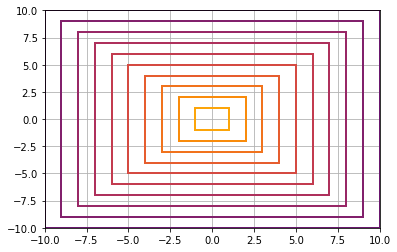

In [14]:
lower_bound1 = (0,0)
upper_bound1 = (0,0)
P0 = Polytope(lb=lower_bound1, ub=upper_bound1)


lower_bound1 = (-1,-1)
upper_bound1 = (1, 1)
disturb = Polytope(lb=lower_bound1, ub=upper_bound1)
fig1, ax1 = plt.subplots(num=1)
plt.grid()
plt.axis([-10, 10, -10, 10])

disturb.plot(ax1, fill=False, edgecolor='r', linewidth=2)

# P2 = P0 + P1
# P2.plot(ax1, fill=False, edgecolor='r', linewidth=2)
N_sample_range = 10
colors = pl.cm.inferno(np.linspace(0.3,0.8,N_sample_range))

P_km1 = P0
for i in range(N_sample_range):
    P_k = P_km1 + disturb
    P_k.plot(ax1, fill=False, edgecolor=colors[N_sample_range - i -1], linewidth=2)
    P_km1 = P_k

(<matplotlib.patches.Polygon at 0x7fbb7f346090>,)

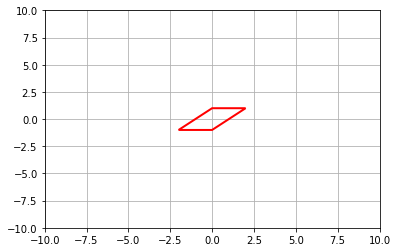

In [15]:
# print('V =\n', disturb.V)
P_km1 = P0

vertice_dis_np = np.array(disturb.V)
ver_rot_np = (A_np @ vertice_dis_np.T).T
# ver_rot_np.shape
P1 = Polytope(ver_rot_np)

fig1, ax1 = plt.subplots(num=1)
plt.grid()
plt.axis([-10, 10, -10, 10])
P1.plot(ax1, fill=False, edgecolor='r', linewidth=2)
# P_1 = P_km1 + disturb



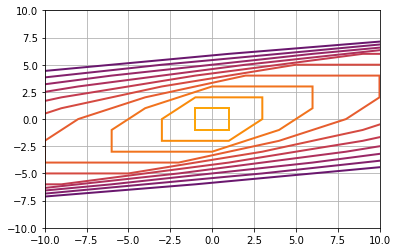

In [16]:
lower_bound1 = (0,0)
upper_bound1 = (0,0)
P0 = Polytope(lb=lower_bound1, ub=upper_bound1)


lower_bound1 = (-1,-1)
upper_bound1 = (1, 1)
disturb = Polytope(lb=lower_bound1, ub=upper_bound1)
fig1, ax1 = plt.subplots(num=1)
plt.grid()
plt.axis([-10, 10, -10, 10])

disturb.plot(ax1, fill=False, edgecolor='r', linewidth=2)

# P2 = P0 + P1
# P2.plot(ax1, fill=False, edgecolor='r', linewidth=2)
N_sample_range = 10
colors = pl.cm.inferno(np.linspace(0.3,0.8,N_sample_range))

P_km1 = P0
for i in range(N_sample_range):
    P_k = P_km1 + disturb
#     P_k = P_km1
    P_k.plot(ax1, fill=False, edgecolor=colors[N_sample_range - i -1], linewidth=2)
    
    vertice_dis_np = np.array(P_k.V)
    ver_rot_np = (A_np @ vertice_dis_np.T).T
    P_k = Polytope(ver_rot_np)
    P_km1 = P_k

#### Case 2:  rotated uncertainty set

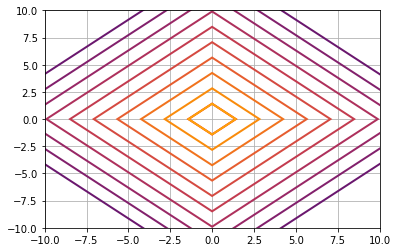

In [17]:
lower_bound1 = (0,0)
upper_bound1 = (0,0)
P0 = Polytope(lb=lower_bound1, ub=upper_bound1)



V_dis = np.array([[np.sqrt(2), 0], [0, -np.sqrt(2)], [-np.sqrt(2), 0], [0, np.sqrt(2)]])
disturb = Polytope(V_dis)
fig1, ax1 = plt.subplots(num=1)
plt.grid()
plt.axis([-10, 10, -10, 10])

disturb.plot(ax1, fill=False, edgecolor='r', linewidth=2)

# P2 = P0 + P1
# P2.plot(ax1, fill=False, edgecolor='r', linewidth=2)
N_sample_range = 10
colors = pl.cm.inferno(np.linspace(0.3,0.8,N_sample_range))

P_km1 = P0
for i in range(N_sample_range):
    P_k = P_km1 + disturb
    P_k.plot(ax1, fill=False, edgecolor=colors[N_sample_range - i -1], linewidth=2)
    P_km1 = P_k

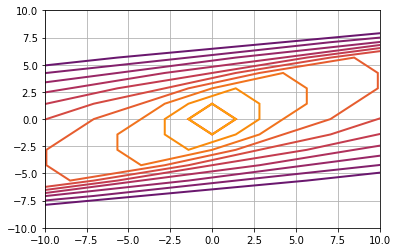

In [18]:
lower_bound1 = (0,0)
upper_bound1 = (0,0)
P0 = Polytope(lb=lower_bound1, ub=upper_bound1)


V_dis = np.array([[np.sqrt(2), 0], [0, -np.sqrt(2)], [-np.sqrt(2), 0], [0, np.sqrt(2)]])
disturb = Polytope(V_dis)
fig1, ax1 = plt.subplots(num=1)
plt.grid()
plt.axis([-10, 10, -10, 10])

disturb.plot(ax1, fill=False, edgecolor='r', linewidth=2)

# P2 = P0 + P1
# P2.plot(ax1, fill=False, edgecolor='r', linewidth=2)
N_sample_range = 10
colors = pl.cm.inferno(np.linspace(0.3,0.8,N_sample_range))

P_km1 = P0
for i in range(N_sample_range):
    P_k = P_km1 + disturb
#     P_k = P_km1
    P_k.plot(ax1, fill=False, edgecolor=colors[N_sample_range - i -1], linewidth=2)
    
    vertice_dis_np = np.array(P_k.V)
    ver_rot_np = (A_np @ vertice_dis_np.T).T
    P_k = Polytope(ver_rot_np)
    P_km1 = P_k

### Simulation 2: closed-loop error propogation (fixed K)

#### Case 1

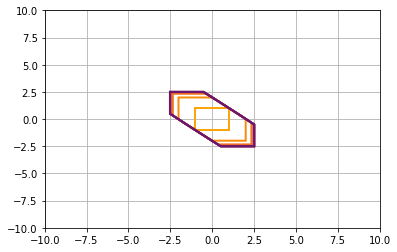

In [27]:
lower_bound1 = (0,0)
upper_bound1 = (0,0)
P0 = Polytope(lb=lower_bound1, ub=upper_bound1)


lower_bound1 = (-1,-1)
upper_bound1 = (1, 1)
disturb = Polytope(lb=lower_bound1, ub=upper_bound1)
fig1, ax1 = plt.subplots(num=1)
plt.grid()
plt.axis([-10, 10, -10, 10])

disturb.plot(ax1, fill=False, edgecolor='r', linewidth=2)

# P2 = P0 + P1
# P2.plot(ax1, fill=False, edgecolor='r', linewidth=2)
N_sample_range = 10
colors = pl.cm.inferno(np.linspace(0.3,0.8,N_sample_range))

P_km1 = P0
for i in range(N_sample_range):
    P_k = P_km1 + disturb
#     P_k = P_km1
    P_k.plot(ax1, fill=False, edgecolor=colors[N_sample_range - i -1], linewidth=2)
    
    vertice_dis_np = np.array(P_k.V)
    ver_rot_np = (Ak_np @ vertice_dis_np.T).T
    P_k = Polytope(ver_rot_np)
    P_km1 = P_k

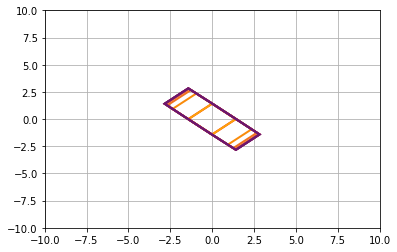

In [28]:
lower_bound1 = (0,0)
upper_bound1 = (0,0)
P0 = Polytope(lb=lower_bound1, ub=upper_bound1)


V_dis = np.array([[np.sqrt(2), 0], [0, -np.sqrt(2)], [-np.sqrt(2), 0], [0, np.sqrt(2)]])
disturb = Polytope(V_dis)
fig1, ax1 = plt.subplots(num=1)
plt.grid()
plt.axis([-10, 10, -10, 10])

disturb.plot(ax1, fill=False, edgecolor='r', linewidth=2)

# P2 = P0 + P1
# P2.plot(ax1, fill=False, edgecolor='r', linewidth=2)
N_sample_range = 10
colors = pl.cm.inferno(np.linspace(0.3,0.8,N_sample_range))

P_km1 = P0
for i in range(N_sample_range):
    P_k = P_km1 + disturb
#     P_k = P_km1
    P_k.plot(ax1, fill=False, edgecolor=colors[N_sample_range - i -1], linewidth=2)
    
    vertice_dis_np = np.array(P_k.V)
    ver_rot_np = (Ak_np @ vertice_dis_np.T).T
    P_k = Polytope(ver_rot_np)
    P_km1 = P_k

In [21]:
np.linalg.eig(Ak_np)

(array([0.33029161, 0.01322247]),
 array([[ 0.70468574, -0.45672452],
        [-0.70951956,  0.88960818]]))

### Simulation 3: evolution of disturbance generated at $t = 0$ (comparsion between open-loop and closed-loop)

#### case 1

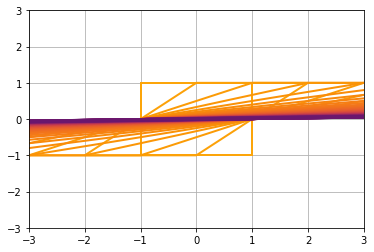

In [22]:
lower_bound1 = (0,0)
upper_bound1 = (0,0)
P0 = Polytope(lb=lower_bound1, ub=upper_bound1)


lower_bound1 = (-1,-1)
upper_bound1 = (1, 1)
disturb = Polytope(lb=lower_bound1, ub=upper_bound1)
fig1, ax1 = plt.subplots(num=1)
plt.grid()
plt.axis([-3, 3, -3, 3])

disturb.plot(ax1, fill=False, edgecolor='r', linewidth=2)

# P2 = P0 + P1
# P2.plot(ax1, fill=False, edgecolor='r', linewidth=2)
N_sample_range = 50
colors = pl.cm.inferno(np.linspace(0.3,0.8,N_sample_range))

P_km1 = P0 + disturb
for i in range(N_sample_range):
    P_k = P_km1
#     P_k = P_km1
    P_k.plot(ax1, fill=False, edgecolor=colors[N_sample_range - i -1], linewidth=2)
    
    vertice_dis_np = np.array(P_k.V)
    ver_rot_np = (A_np @ vertice_dis_np.T).T
    P_k = Polytope(ver_rot_np)
    P_km1 = P_k

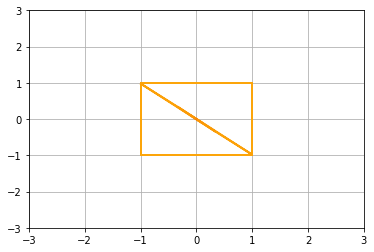

In [30]:
lower_bound1 = (0,0)
upper_bound1 = (0,0)
P0 = Polytope(lb=lower_bound1, ub=upper_bound1)


lower_bound1 = (-1,-1)
upper_bound1 = (1, 1)
disturb = Polytope(lb=lower_bound1, ub=upper_bound1)
fig1, ax1 = plt.subplots(num=1)
plt.grid()
plt.axis([-3, 3, -3, 3])

disturb.plot(ax1, fill=False, edgecolor='r', linewidth=2)

# P2 = P0 + P1
# P2.plot(ax1, fill=False, edgecolor='r', linewidth=2)
N_sample_range = 50
colors = pl.cm.inferno(np.linspace(0.3,0.8,N_sample_range))

P_km1 = P0 + disturb
for i in range(N_sample_range):
    P_k = P_km1
#     P_k = P_km1
    P_k.plot(ax1, fill=False, edgecolor=colors[N_sample_range - i -1], linewidth=2)
    
    vertice_dis_np = np.array(P_k.V)
    ver_rot_np = (Ak_np @ vertice_dis_np.T).T
    P_k = Polytope(ver_rot_np)
    P_km1 = P_k

#### Case 2

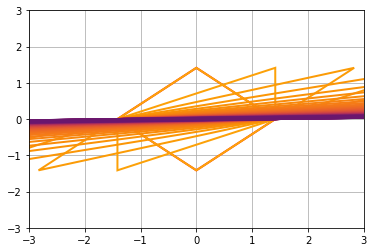

In [31]:
lower_bound1 = (0,0)
upper_bound1 = (0,0)
P0 = Polytope(lb=lower_bound1, ub=upper_bound1)


V_dis = np.array([[np.sqrt(2), 0], [0, -np.sqrt(2)], [-np.sqrt(2), 0], [0, np.sqrt(2)]])
disturb = Polytope(V_dis)
fig1, ax1 = plt.subplots(num=1)
plt.grid()
plt.axis([-3, 3, -3, 3])

disturb.plot(ax1, fill=False, edgecolor='r', linewidth=2)

# P2 = P0 + P1
# P2.plot(ax1, fill=False, edgecolor='r', linewidth=2)
N_sample_range = 50
colors = pl.cm.inferno(np.linspace(0.3,0.8,N_sample_range))

P_km1 = P0 + disturb
for i in range(N_sample_range):
    P_k = P_km1
#     P_k = P_km1
    P_k.plot(ax1, fill=False, edgecolor=colors[N_sample_range - i -1], linewidth=2)
    
    vertice_dis_np = np.array(P_k.V)
    ver_rot_np = (A_np @ vertice_dis_np.T).T
    P_k = Polytope(ver_rot_np)
    P_km1 = P_k

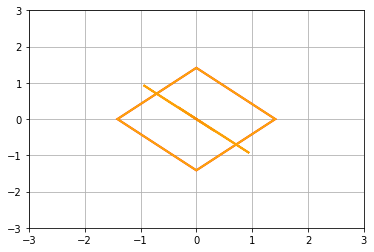

In [37]:
lower_bound1 = (0,0)
upper_bound1 = (0,0)
P0 = Polytope(lb=lower_bound1, ub=upper_bound1)


V_dis = np.array([[np.sqrt(2), 0], [0, -np.sqrt(2)], [-np.sqrt(2), 0], [0, np.sqrt(2)]])
disturb = Polytope(V_dis)
fig1, ax1 = plt.subplots(num=1)
plt.grid()
plt.axis([-3, 3, -3, 3])

disturb.plot(ax1, fill=False, edgecolor='r', linewidth=2)

# P2 = P0 + P1
# P2.plot(ax1, fill=False, edgecolor='r', linewidth=2)
N_sample_range = 50
colors = pl.cm.inferno(np.linspace(0.3,0.8,N_sample_range))

P_km1 = P0 + disturb
for i in range(N_sample_range):
    P_k = P_km1 
#     P_k = P_km1
    P_k.plot(ax1, fill=False, edgecolor=colors[N_sample_range - i -1], linewidth=2)
    
    vertice_dis_np = np.array(P_k.V)
    ver_rot_np = (Ak_np @ vertice_dis_np.T).T
    P_k = Polytope(ver_rot_np)
    P_km1 = P_k

### Simulation 3: Propogation of trajectories  $\| w_k\|_{\infty} \le 0.5$

In [282]:
w_val = 0.2

In [283]:
nw = 2

N_sim = 100
N_loop = 50

Case 1: A+BK

In [284]:
x0 = np.array([[-5],[-2]])
xk = x0

x_diff_traj_list = []


for j in range(N_loop):
    xk = x0
    x_traj_list = []
    x_traj_list += [xk]
    
    for i in range(N_sim):  
        uk = K_np @ xk
    #     uk = vk + K @ (xk - x0_sol)
        wk = np.random.uniform(-w_val,w_val,(2,1))
        xk_next = A_np @ xk + B_np @ uk + wk
        x_traj_list += [xk_next]
        xk = xk_next
    x_diff_traj_list += [x_traj_list]

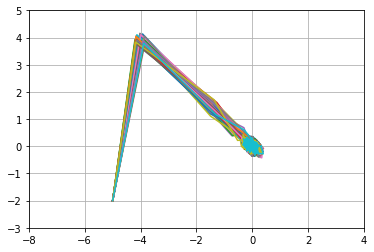

In [285]:
fig1, ax1 = plt.subplots(num=1)

plt.grid()
plt.axis([-8, 4, -3, 5])

# P_VT.plot(ax10, fill=False, edgecolor='r', linewidth=2)
for i in range(N_loop):
    x_traj_array = np.hstack(x_diff_traj_list[i])
    ax1.plot(x_traj_array[0,:],x_traj_array[1,:])

case 2: nominal MPC

In [286]:
N_pred = 9

u_ub = [1]
u_lb = [-1]

x_ub = [ca.inf, 2]
x_lb = [-ca.inf, -ca.inf]

xi_var = ca.SX.sym('x', nx, N_pred)
x0_para = ca.SX.sym('x0', nx, 1)
ui_var = ca.SX.sym('u', nu, N_pred - 1)

obj = 0
g = []
g += [x0_para - xi_var[:, 0]]
for i in range(N_pred - 1):
    xk = xi_var[:, i]
    obj += xk.T @ Q @ xk +ui_var[:, i].T @ R @ ui_var[:, i]
    
    g += [xi_var[:, i+1] - (A_DM @ xk + B_DM @ ui_var[:, i])]

# obj += xi_var[:, -1].T @ P @ xi_var[:, -1]
obj += xi_var[:, -1].T @ Q @ xi_var[:, -1]
# g += [xi_var[:, -1] - (A_para @ xi_var[:, -2] + B_para @ ui_var[:,  -1])] # Terminal state

dec_list = [ca.reshape(xi_var, -1, 1), ca.reshape(ui_var, -1, 1)]
para_list = [x0_para]

nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 300,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}

solver = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)

In [287]:
nl = {}

lbg = [0] * (nx * N_pred)
ubg = [0] * (nx * N_pred)

nl['lbg'] = lbg
nl['ubg'] = ubg

lbx = x_lb * N_pred + u_lb * (N_pred - 1)
ubx = x_ub * N_pred + u_ub * (N_pred - 1)

nl['lbx'] = lbx
nl['ubx'] = ubx

x_diff_traj_list = []

for j in range(N_loop):
    xk = x0
    x_traj_list = []
    x_traj_list += [xk]

    for i in range(N_sim):  
        nl['p'] = xk
        sol = solver(**nl)
        uk = sol['x'][nx * N_pred : nx * N_pred + nu].full()

        wk = np.random.uniform(-w_val,w_val,[2,1])
        xk_next = A_np @ xk + B_np @ uk + wk
        x_traj_list += [xk_next]

        xk = xk_next
    x_diff_traj_list += [x_traj_list]

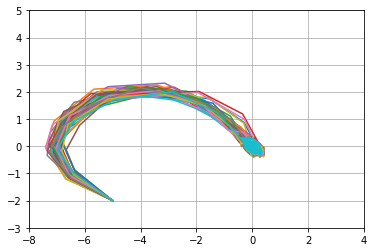

In [288]:
fig1, ax1 = plt.subplots(num=2)

plt.grid()
plt.axis([-8, 4, -3, 5])

# P_VT.plot(ax10, fill=False, edgecolor='r', linewidth=2)
for i in range(N_loop):
    x_traj_array = np.hstack(x_diff_traj_list[i])
    ax1.plot(x_traj_array[0,:],x_traj_array[1,:])

### tighten constraint

In [289]:
nl = {}

lbg = [0] * (nx * N_pred)
ubg = [0] * (nx * N_pred)

nl['lbg'] = lbg
nl['ubg'] = ubg

x_ub_tighted = [ca.inf, 1.9]

lbx = x_lb * N_pred + u_lb * (N_pred - 1)
ubx = x_ub_tighted * N_pred + u_ub * (N_pred - 1)

nl['lbx'] = lbx
nl['ubx'] = ubx



x_diff_traj_list = []

for j in range(N_loop):
    xk = x0
    x_traj_list = []
    x_traj_list += [xk]
    for i in range(N_sim):  
        nl['p'] = xk
        sol = solver(**nl)
        uk = sol['x'][nx * N_pred : nx * N_pred + nu].full()

        wk = np.random.uniform(-w_val,w_val,[2,1])
        xk_next = A_np @ xk + B_np @ uk + wk
        x_traj_list += [xk_next]

        xk = xk_next
    x_diff_traj_list += [x_traj_list]

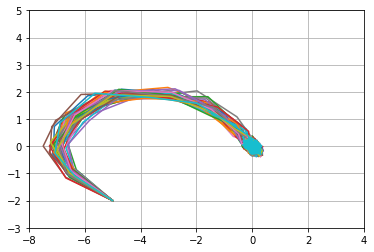

In [290]:
fig1, ax1 = plt.subplots(num=3)

plt.grid()
plt.axis([-8, 4, -3, 5])

# P_VT.plot(ax10, fill=False, edgecolor='r', linewidth=2)
for i in range(N_loop):
    x_traj_array = np.hstack(x_diff_traj_list[i])
    ax1.plot(x_traj_array[0,:],x_traj_array[1,:])

#### Calculation of tightened upper bound

In [291]:
F_np = np.array([[0,1/2],[0,0],[0,0]])
G_np = np.array([[0],[1],[-1]])
F_tilde_np = F_np + G_np @ K_np

In [292]:
obj.shape

(1, 1)

In [293]:
N_dis_acc = 10

w_dec_SX = ca.SX.sym('w', nw, 1)
mat_dec_row_SX = ca.SX.sym("mat_dec_row", 1, nw)

obj = - mat_dec_row_SX @ w_dec_SX

bound_tight_nlp_prob = {
    'f': obj,
    'x': w_dec_SX,
    'p': mat_dec_row_SX
}

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 300,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}

bt_solver = ca.nlpsol("solver", "ipopt", bound_tight_nlp_prob, solver_opt)

In [294]:
mat_lfh_temp

DM(
[[9.68412e-05, 4.97182e-05], 
 [-9.75054e-05, -5.00593e-05]])

In [295]:
nl = {}

nl['lbx'] = [-w_val, -w_val]
nl['ubx'] = [w_val, w_val]

alpha_list = []
w_list = []
for i in range(1,N_dis_acc):
    mat_lfh_temp = ca.mpower(Ak_DM,i)
    w_temp_list = []
    alpha_temp_list = []
    for j in range(3):
        nl['p'] = (F_tilde_np @ mat_lfh_temp)[j,:]
        sol = bt_solver(**nl)
        
        w_temp = sol['x'].full()
        alpha_temp = sol['f']
        
        alpha_temp_list += [alpha_temp]
        w_temp_list += [w_temp]
        
    alpha_list += [np.array(alpha_temp_list).reshape(-1,1)]
    w_list += [np.array(w_temp_list).reshape(-1,1)]

In [296]:
alpha_list

[array([[-0.09869125],
        [-0.12870538],
        [-0.12870538]]),
 array([[-0.03433856],
        [-0.04594758],
        [-0.04594758]]),
 array([[-0.01136476],
        [-0.01522155],
        [-0.01522155]]),
 array([[-0.00375399],
        [-0.00502815],
        [-0.00502815]]),
 array([[-0.00123991],
        [-0.00166075],
        [-0.00166075]]),
 array([[-0.00040952],
        [-0.00054853],
        [-0.00054853]]),
 array([[-0.00013526],
        [-0.00018118],
        [-0.00018118]]),
 array([[-4.46752804e-05],
        [-5.98394376e-05],
        [-5.98394376e-05]]),
 array([[-1.47522100e-05],
        [-1.97607859e-05],
        [-1.97607859e-05]])]

In [297]:
alpha_result = np.zeros([3,1])

for i in alpha_list:
    alpha_result += i

In [298]:
bt_value = -alpha_result
bt_value

array([[0.14999268],
       [0.19737273],
       [0.19737273]])

In [299]:
-alpha_result.flatten()

array([0.14999268, 0.19737273, 0.19737273])

#### Calculation of exactly tightened upper bound

In [300]:
nl = {}

lbg = [0] * (nx * N_pred)
ubg = [0] * (nx * N_pred)

nl['lbg'] = lbg
nl['ubg'] = ubg

x_ub_tighted = [ca.inf, 2.0 - 2* bt_value.flatten()[0]]
u_lb_tighted = [-1 + bt_value.flatten()[2]]
u_ub_tighted = [1 - bt_value.flatten()[1]]


lbx = x_lb * N_pred + u_lb_tighted * (N_pred - 1)
ubx = x_ub_tighted * N_pred + u_ub_tighted * (N_pred - 1)

nl['lbx'] = lbx
nl['ubx'] = ubx



x_diff_traj_list = []

for j in range(N_loop):
    xk = x0
    x_traj_list = []
    x_traj_list += [xk]
    for i in range(N_sim): 
        if xk[1] >= 2:
            print(xk[1])
        nl['p'] = xk
        sol = solver(**nl)
        uk = sol['x'][nx * N_pred : nx * N_pred + nu].full()

        wk = np.random.uniform(-w_val,w_val,[2,1])
        xk_next = A_np @ xk + B_np @ uk + wk
        x_traj_list += [xk_next]

        xk = xk_next
    x_diff_traj_list += [x_traj_list]

[2.03861396]


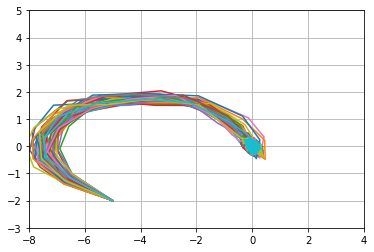

In [301]:
fig1, ax1 = plt.subplots(num=4)

plt.grid()
plt.axis([-8, 4, -3, 5])

# P_VT.plot(ax10, fill=False, edgecolor='r', linewidth=2)
for i in range(N_loop):
    x_traj_array = np.hstack(x_diff_traj_list[i])
    ax1.plot(x_traj_array[0,:],x_traj_array[1,:])

#### Unfeasibility